In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/icml_face_data.csv'
data = pd.read_csv(path)

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [8]:
width, height = 48, 48
datapoints = data[' pixels'].tolist()

X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).to_numpy()

#storing them using numpy
#np.save('fdataX', X)
#np.save('flabels', y)

#print("Preprocessing Done")
#print("Number of Features: "+str(len(X[0])))
#print("Number of Labels: "+ str(len(y[0])))
#print("Number of examples in dataset:"+str(len(X)))
#print("X,y stored in fdataX.npy and flabels.npy respectively")

In [9]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [11]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

#x = np.load('./fdataX.npy')
#y = np.load('./flabels.npy')

X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

In [12]:
#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
#np.save('modXtest', X_test)
#np.save('modytest', y_test)

#desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [13]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [15]:
history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

Epoch 1/100
455/455 [==============================] - 27s 60ms/step - loss: 1.9891 - accuracy: 0.2124 - val_loss: 1.8213 - val_accuracy: 0.2594
Epoch 2/100
455/455 [==============================] - 26s 58ms/step - loss: 1.8352 - accuracy: 0.2453 - val_loss: 1.7987 - val_accuracy: 0.2598
Epoch 3/100
455/455 [==============================] - 26s 58ms/step - loss: 1.7470 - accuracy: 0.2867 - val_loss: 1.6134 - val_accuracy: 0.3508
Epoch 4/100
455/455 [==============================] - 26s 58ms/step - loss: 1.6081 - accuracy: 0.3659 - val_loss: 1.4663 - val_accuracy: 0.4319
Epoch 5/100
455/455 [==============================] - 26s 58ms/step - loss: 1.5078 - accuracy: 0.4134 - val_loss: 1.3834 - val_accuracy: 0.4344
Epoch 6/100
455/455 [==============================] - 26s 58ms/step - loss: 1.4522 - accuracy: 0.4329 - val_loss: 1.3460 - val_accuracy: 0.4734
Epoch 7/100
455/455 [==============================] - 26s 58ms/step - loss: 1.4102 - accuracy: 0.4519 - val_loss: 1.3082 - val_ac

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 12ms/step - loss: 1.5030 - accuracy: 0.6565
test caccuracy: 0.6564502716064453


In [18]:
pred_test_labels = model.predict(X_test)

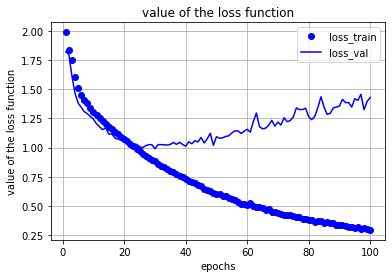

In [19]:
import matplotlib.pyplot as plt
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

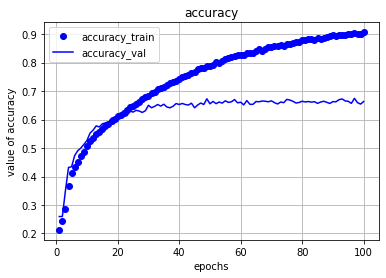

In [20]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

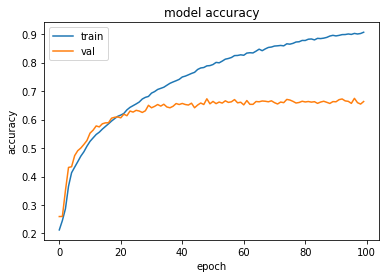

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

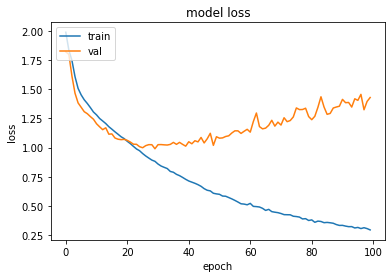

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Saved model to disk
